In [1]:
%load_ext line_profiler

In [2]:
from collections import Counter
from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [248]:
# ns = [0,10,10,11,12,13,14,15,16,17]
# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# ns = [0]


students = np.logspace(-1, 1, 21)
display(students.round(4))

# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 5
# # arrs = np.array([[20,0,0,0,0],
# #                  [19,19,0,0,0],
# #                  [18,18,18,0,0],
# #                  [17,17,17,17,0],
# #                  [16,16,16,16,16],])
# arrs = np.array([[20,0,0,0,0],
#                  [15,16,17,18,19],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                 ])
# arrs = arrs / 20
# display(arrs)
# display(arrs.sum().round(2))


ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
ms = 10
arrs = np.array([[20,0,0,0,0,0,0,0,0,0],
                 [19,18,17,16,15,14,13,12,11,10],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                ])
arrs = arrs / 20
display(arrs)
display(arrs.sum().round(2))
                 
                 

# ms = 4
# arrs = np.triu(np.tile(np.arange(31, 35),(4,1)).T) - 20
# display(arrs)
# display(arrs.sum())


# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 2
# arrs = np.array([[1,0],[.99,.99]])
# display(arrs)
# display(arrs.sum().round(2))


ranked = False
slip = True

array([ 0.1   ,  0.1259,  0.1585,  0.1995,  0.2512,  0.3162,  0.3981,  0.5012,  0.631 ,  0.7943,  1.    ,  1.2589,  1.5849,  1.9953,  2.5119,  3.1623,  3.9811,  5.0119,  6.3096,
        7.9433, 10.    ])

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

8.25

In [283]:
def make_model(num_nodes=128, num_dense=4):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    
    inputs = tf.keras.layers.Input(shape=(ms*ms + ms + 1))
    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(num_dense):
        x = tf.keras.layers.Dense(num_nodes, activation='relu')(x)
    output1 = tf.keras.layers.Dense(ms, name='Y0')(x)
    output1 = tf.keras.layers.Softmax()(output1)
    model = tf.keras.models.Model(inputs=inputs, outputs=output1)
    
    opt = tf.keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1)
    # opt = tf.keras.optimizers.SGD()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return model

def softmax(x, b, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x/b) / np.exp(x/b).sum(axis=axis, keepdims=True)

# def softmax(x, b, axis=-1):
#     x = x - np.max(x)
#     with np.errstate(divide='ignore', invalid='ignore'):
#         res = np.exp(x/b) / np.exp(x/b).sum(axis=-1, keepdims=True)
#         res = np.nan_to_num(res)
#     return res

def make_x():
    x = arrs
    
    # rand = np.random.random(arrs.shape)
    # rand = (rand - 0.5)
    # x = x + rand*0.0001
    
    x = rng.permuted(x, axis=-1)
    return x

def eval_model(model, n = 1, disable=True):
    rewards = []
    branch_rewards = []
    for _ in trange(n, disable=disable):
        x = make_x()
        x_tree = np.concatenate([np.eye(ms+1).astype(int), np.tile(x.flatten(), (ms+1,1))], axis=1)
        y_pred = model(x_tree)
        branch_reward = (x_tree[0,ms+1:].reshape(ms,ms) * y_pred[1:].numpy()).sum(axis=1)
        rewards.append(y_pred[0].numpy())
        # reward = (y_pred[0] * branch_reward).numpy().sum()
        # rewards.append(reward)
        branch_rewards.append(branch_reward)
    return np.array(rewards), np.array(branch_rewards)

def make_data(b=1, n=1, disable=True):
    X, Y = [], []
    for _ in trange(n, disable=disable):
        
        if ranked:
            x = make_x()
            r1 = softmax(rankdata(x,axis=1), b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(rankdata(r1sum), b)
                    
        else:
            x = make_x()
            r1 = softmax(x, b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(r1sum, b)
        
        pos = [0] * (ms+1)
        pos[0] = 1
        x0 = pos + list(x.flatten())
        
        
        # slip_prob = np.log10(b)/-20 + 0.95
        slip_prob = np.log10(b) * -0.45 + 0.55
        
        if slip == False:
            y0 = rng.choice(np.arange(ms), p=r0)
        else:
            p = np.zeros(ms) + (1-slip_prob)/(ms-1)
            p[0] = slip_prob
            y0 = rng.choice(np.arange(ms), p=p)
        # while y0 in [2,3,4]:
        #     y0 = rng.choice(np.arange(ms), p=r0)
            
        
        pos = [0] * (ms+1)
        pos[y0+1] = 1
        x1 = pos + list(x.flatten())
        
        if slip == False:
            y1 = rng.choice(np.arange(ms), p=r1[y0])
        else:
            p = np.zeros(ms) + (1-slip_prob)/(ms-1)
            
            p[r1.argmax()] = slip_prob
            y1 = rng.choice(np.arange(ms), p=p)

        X.append(x0)
        Y.append(y0)
        X.append(x1)
        Y.append(y1)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [284]:
%%time
for b in students:
    r0s = []
    r1s = []
    for _ in trange(10000, disable=True):
        x = make_x()
        
        if ranked:
            r1 = (softmax(rankdata(x,axis=1), b) * x).sum(axis=1)
            r0 = (softmax(rankdata(r1), b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
            
        else:
            r1 = (softmax(x, b) * x).sum(axis=1)
            r0 = (softmax(r1, b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
    
        
    r1s = np.array(r1s)
    r0s = np.array(r0s)
    print(f"{b:.3f}, {r0s.mean():.3f}, {r1s.mean(axis=0).round(3)}, {softmax(r1s.mean(axis=0), b).round(3)}")

0.100, 0.971, [1.    0.876 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.774 0.226 0.    0.    0.    0.    0.    0.    0.    0.   ]
0.126, 0.960, [0.997 0.857 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.751 0.247 0.    0.    0.    0.    0.    0.    0.    0.   ]
0.158, 0.932, [0.984 0.837 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.708 0.281 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
0.200, 0.860, [0.943 0.819 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.623 0.333 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006]
0.251, 0.726, [0.856 0.802 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.483 0.389 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016]
0.316, 0.556, [0.724 0.788 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.33  0.403 0.033 0.033 0.033 0.033 0.033 0.033 0.033 0.033]
0.398, 0.410, [0.578 0.775 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.221 0.364 0.052 0.052 0.052 0.052 0.052 0.052 0.052 0.052]
0.501, 0.307, [0.45  0.765 

In [285]:
def train_model(student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/starting_{student:.3f}.keras')
    return reward

In [286]:
%%time
rewards = process_map(train_model, students, disable=True, max_workers=24)

student == 1.000


  0%|          | 0/65536 [00:00<?, ?it/s]

4096/4096 [==============================] - 60s 14ms/step - loss: 1.6995 - accuracy: 0.5477


  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1.95 s, sys: 2 s, total: 3.94 s
Wall time: 3min 35s


In [287]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

0.100 0.9999987002866015
0.126 0.89839028819322
0.158 0.7940961529705882
0.200 0.6980048699105443
0.251 0.6490397328859817
0.316 0.5954645590322705
0.398 0.5871891786379716
0.501 0.4462571121309913
0.631 0.42273821607669254
0.794 0.358589867581507
1.000 0.35711635538395614
1.259 0.2746957487740706
1.585 0.24128950480653402
1.995 0.1933464098777884
2.512 0.16983296884896132
3.162 0.14740630237663496
3.981 0.13584599357359217
5.012 0.11933573966505205
6.310 0.09759202064894353
7.943 0.08929530014902157
10.000 0.08307802676424525


# Graphs

In [ ]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.get_logger().setLevel('ERROR')
model2 = tf.keras.models.load_model(f"models/starting_{0.100:.3f}.keras")
%timeit r0, r1 = eval_model(model2, 1)

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_batch_end(self, batch, logs=None):
        r0, r1 = eval_model(self.model, 10)
        r = (r0*r1).sum(axis=1).mean()
        
        
        try:
            self.model.rewards.append(r)
            self.model.accs.append(logs['accuracy'])
        except:
            self.model.rewards = [r]
            self.model.accs = [logs['accuracy']]

#         # Add the output to the logs
#         if logs is not None:
#             logs['reward'] = r

In [ ]:
models = {}

In [ ]:
%%time

with open('tree.log', 'a') as f:
    for student in students:
        
        print(f'student {student:.3f}', file=f, flush=True)

        models[student] = {}

        for teacher in students[::2][3:10]:

            print(f'teacher {teacher:.3f}', file=f, flush=True)
            models[student][teacher] = []
            for i in range(5):
                print(f'model {i}', file=f, flush=True)
                # model = make_model()
                model = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")

                opt = tf.keras.optimizers.Adam()
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

                X, Y = currs[f'{teacher:.3f}']
                model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()], verbose=False)
                # model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()])

                models[student][teacher].append(model)


        #         break
        #     break
        # break

In [ ]:
for student, s_models in models.items():
    # print(student, list(s_models))
    df = {}
    for teacher, model in s_models.items():
        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        rewards = np.array([m.rewards for m in model]).mean(axis=0)
        rewards = np.convolve(rewards, kernel, mode='valid')
        df[f"{teacher:.3f}"] = rewards
    df = pd.DataFrame(df)
    
    print(f'Student {student:.3f}')
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.lineplot(df[[c for c in df.columns if float(c) >= student]])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.show()
    print()

In [ ]:
df[[c for c in df.columns if float(c) >= 1]]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
1+1

In [ ]:
ax = sns.lineplot(df[df.columns[4:9]])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
students[::2][4:9]

# Eval Training

In [288]:
def eval_training(student, teacher, verbose=False):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")
    # opt = tf.keras.optimizers.SGD()
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    nsum = 0
    
    X, Y = currs[f"{teacher:.3f}"]
    perm = np.random.permutation(len(X))
    X, Y = X[perm], Y[perm]
    
    rewards = []
    for i in ns:
        if i != 0:
            n = 2**i
            # X, Y = make_data(teacher, n, disable=True)
                        
            model2.fit(X[nsum:nsum+n], Y[nsum:nsum+n], verbose=False)
            nsum += n
            
        r0, r1 = eval_model(model2, 10)
        reward = (r0*r1).sum(axis=1).mean()
        rewards.append(reward)
        # print(f"{nsum}    ", end='\r')
    return rewards

In [289]:
def exp(student, verbose=True, n=20):
    # teachers = np.arange(student, 0.40001, 0.02)
    
    teachers = students
    
    t_ = list(teachers) * n
    s_ = [student for _ in t_]
    
    res = process_map(eval_training, s_, t_, max_workers=5, chunksize=1)
    
    return np.array(res)

In [290]:
%%time
ntotal = (2**np.array(ns[1:])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=6, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 926 ms, sys: 2.22 s, total: 3.14 s
Wall time: 46.5 s


In [291]:
%%time
exp(-1, n=10).reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/210 [00:00<?, ?it/s]

CPU times: user 387 ms, sys: 161 ms, total: 548 ms
Wall time: 10min 52s


array([[0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.14, 0.49, 0.99, 1.  , 1.  , 1.  , 1.  ],
       [0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.14, 0.41, 0.84, 0.89, 0.9 , 0.9 , 0.91],
       [0.08, 0.08, 0.08, 0.09, 0.09, 0.1 , 0.14, 0.34, 0.77, 0.79, 0.83, 0.83, 0.82],
       [0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.13, 0.28, 0.69, 0.75, 0.77, 0.73, 0.76],
       [0.08, 0.08, 0.09, 0.08, 0.09, 0.09, 0.13, 0.22, 0.6 , 0.67, 0.7 , 0.65, 0.69],
       [0.08, 0.09, 0.08, 0.09, 0.09, 0.09, 0.11, 0.2 , 0.55, 0.6 , 0.63, 0.61, 0.61],
       [0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.11, 0.19, 0.47, 0.54, 0.53, 0.54, 0.54],
       [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.11, 0.16, 0.43, 0.48, 0.46, 0.47, 0.49],
       [0.08, 0.09, 0.09, 0.09, 0.09, 0.1 , 0.11, 0.15, 0.35, 0.44, 0.43, 0.41, 0.45],
       [0.08, 0.08, 0.08, 0.09, 0.09, 0.1 , 0.1 , 0.13, 0.28, 0.37, 0.37, 0.39, 0.36],
       [0.08, 0.08, 0.08, 0.08, 0.09, 0.1 , 0.1 , 0.13, 0.24, 0.3 , 0.35, 0.34, 0.34],
       [0.08, 0.08, 0.08, 0.08, 0.08, 0.1 ,

In [292]:
%%time
exp(1, n=10).reshape(-1, len(students), len(ns)).mean(axis=0).round(3)

  0%|          | 0/210 [00:00<?, ?it/s]

CPU times: user 399 ms, sys: 179 ms, total: 577 ms
Wall time: 11min 5s


array([[0.357, 0.421, 0.46 , 0.599, 0.823, 0.985, 0.999, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ],
       [0.358, 0.415, 0.458, 0.585, 0.79 , 0.954, 0.939, 0.91 , 0.906, 0.904, 0.91 , 0.914, 0.911],
       [0.36 , 0.409, 0.455, 0.575, 0.761, 0.913, 0.841, 0.829, 0.824, 0.838, 0.81 , 0.833, 0.839],
       [0.356, 0.405, 0.452, 0.553, 0.728, 0.838, 0.767, 0.747, 0.769, 0.758, 0.776, 0.752, 0.748],
       [0.354, 0.399, 0.453, 0.539, 0.683, 0.77 , 0.657, 0.672, 0.657, 0.655, 0.66 , 0.683, 0.694],
       [0.36 , 0.395, 0.443, 0.522, 0.615, 0.66 , 0.612, 0.592, 0.609, 0.637, 0.594, 0.614, 0.613],
       [0.36 , 0.381, 0.416, 0.479, 0.572, 0.605, 0.537, 0.532, 0.532, 0.538, 0.544, 0.552, 0.557],
       [0.358, 0.382, 0.409, 0.45 , 0.503, 0.509, 0.489, 0.472, 0.498, 0.506, 0.504, 0.491, 0.498],
       [0.361, 0.368, 0.384, 0.407, 0.43 , 0.452, 0.442, 0.416, 0.436, 0.429, 0.443, 0.431, 0.447],
       [0.36 , 0.362, 0.372, 0.378, 0.385, 0.388, 0.37 , 0.397, 0.383, 0.366, 0.374, 0.369, 0.393],


In [293]:
%%time
exp(10, n=10).reshape(-1, len(students), len(ns)).mean(axis=0).round(3)

  0%|          | 0/210 [00:00<?, ?it/s]

CPU times: user 364 ms, sys: 193 ms, total: 558 ms
Wall time: 11min 7s


array([[0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.081, 0.111, 0.502, 0.992, 0.999, 1.   , 1.   ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.081, 0.106, 0.355, 0.836, 0.897, 0.886, 0.9  ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.107, 0.294, 0.77 , 0.813, 0.828, 0.821],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.093, 0.228, 0.642, 0.738, 0.733, 0.742],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.101, 0.217, 0.564, 0.659, 0.673, 0.663],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.096, 0.186, 0.496, 0.603, 0.616, 0.6  ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.103, 0.178, 0.421, 0.535, 0.532, 0.534],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.089, 0.141, 0.345, 0.475, 0.476, 0.477],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.105, 0.129, 0.303, 0.443, 0.442, 0.442],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.089, 0.117, 0.237, 0.356, 0.371, 0.375],


In [295]:
_293[[0,2,4,6]]

array([[0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.081, 0.111, 0.502, 0.992, 0.999, 1.   , 1.   ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.107, 0.294, 0.77 , 0.813, 0.828, 0.821],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.101, 0.217, 0.564, 0.659, 0.673, 0.663],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.103, 0.178, 0.421, 0.535, 0.532, 0.534]])

In [301]:
_293[0,1,2,3,4]

array([[0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.081, 0.111, 0.502, 0.992, 0.999, 1.   , 1.   ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.081, 0.106, 0.355, 0.836, 0.897, 0.886, 0.9  ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.107, 0.294, 0.77 , 0.813, 0.828, 0.821],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.093, 0.228, 0.642, 0.738, 0.733, 0.742],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.101, 0.217, 0.564, 0.659, 0.673, 0.663],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.096, 0.186, 0.496, 0.603, 0.616, 0.6  ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.103, 0.178, 0.421, 0.535, 0.532, 0.534],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.089, 0.141, 0.345, 0.475, 0.476, 0.477],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.105, 0.129, 0.303, 0.443, 0.442, 0.442],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.089, 0.117, 0.237, 0.356, 0.371, 0.375],


In [ ]:
old[0,3,4]

In [296]:
old = np.array([[0.084, 0.084, 0.084, 0.085, 0.085, 0.088, 0.102, 0.214, 0.305, 0.737, 0.91 , 0.928, 0.93 ],
                [0.084, 0.084, 0.084, 0.085, 0.085, 0.088, 0.102, 0.237, 0.314, 0.772, 0.914, 0.917, 0.93 ],
                [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.103, 0.275, 0.343, 0.684, 0.877, 0.897, 0.904],
                [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.104, 0.301, 0.356, 0.609, 0.788, 0.833, 0.829],
                [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.107, 0.276, 0.329, 0.419, 0.638, 0.656, 0.695],
                [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.113, 0.26 , 0.305, 0.316, 0.45 , 0.516, 0.545],
                [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.1  , 0.235, 0.314, 0.276, 0.273, 0.354, 0.374],
                [0.084, 0.084, 0.085, 0.085, 0.085, 0.087, 0.094, 0.19 , 0.247, 0.252, 0.244, 0.221, 0.249],
                [0.084, 0.084, 0.085, 0.085, 0.085, 0.086, 0.093, 0.141, 0.175, 0.2  , 0.211, 0.204, 0.175],
                [0.084, 0.084, 0.085, 0.085, 0.085, 0.086, 0.089, 0.112, 0.137, 0.173, 0.171, 0.194, 0.177],
                [0.084, 0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.097, 0.115, 0.117, 0.129, 0.147, 0.128],
                [0.084, 0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.091, 0.103, 0.117, 0.11 , 0.123, 0.135],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.086, 0.087, 0.093, 0.099, 0.111, 0.116, 0.115],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.087, 0.09 , 0.096, 0.1  , 0.1  , 0.106],
                [0.084, 0.084, 0.084, 0.085, 0.085, 0.085, 0.086, 0.088, 0.086, 0.096, 0.101, 0.097, 0.101],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.085, 0.086, 0.086, 0.09 , 0.088, 0.092, 0.096],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.086, 0.086, 0.087, 0.088, 0.091, 0.09 ],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.084, 0.086, 0.088, 0.087, 0.088],
                [0.084, 0.084, 0.084, 0.085, 0.085, 0.085, 0.084, 0.085, 0.086, 0.087, 0.088, 0.088, 0.087],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.085, 0.085, 0.084, 0.086, 0.085],
                [0.084, 0.084, 0.084, 0.084, 0.084, 0.085, 0.085, 0.084, 0.085, 0.085, 0.083, 0.087, 0.086]])

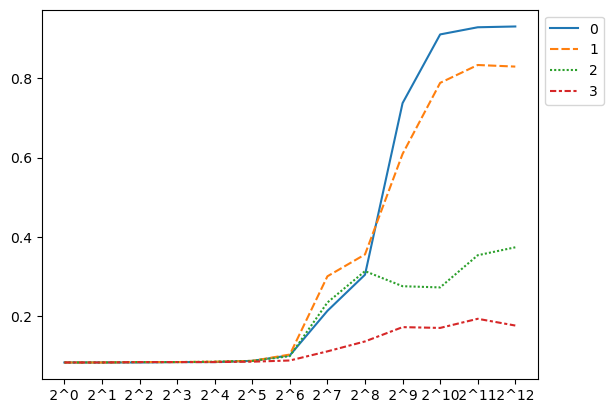

In [336]:
df = pd.DataFrame(old[[0,3,6,9]].T)
df.index = " 2^" + df.index.astype(str) + " "
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [332]:
df.index = "2^" + df.index.astype(str)

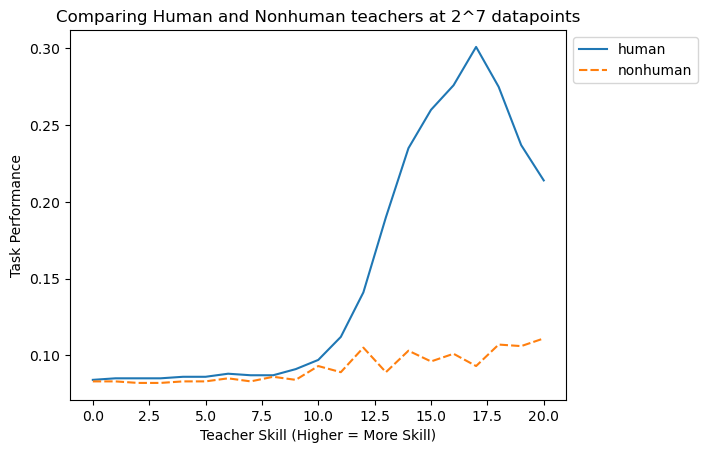

In [338]:
df = pd.DataFrame(np.stack([old[:,7],_293[:,7]]).T[::-1])
df = df.rename(columns={0:'human', 1:'nonhuman'})
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(xlabel='Teacher Skill (Higher = More Skill)',
           ylabel='Task Performance',
           title='Comparing Human and Nonhuman teachers at 2^7 datapoints')

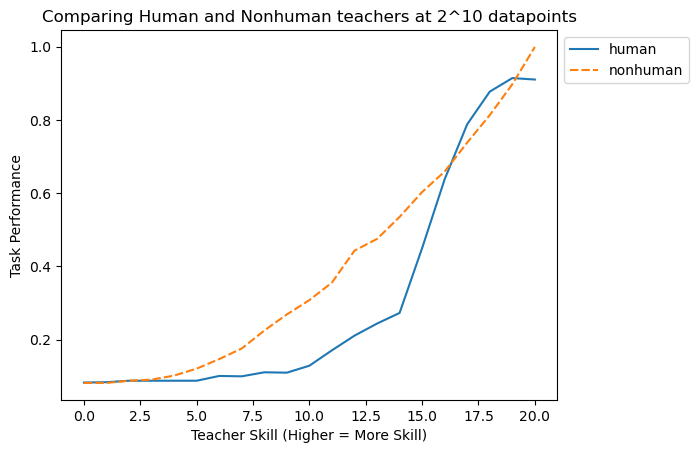

In [339]:
df = pd.DataFrame(np.stack([old[:,10],_293[:,10]]).T[::-1])
df = df.rename(columns={0:'human', 1:'nonhuman'})
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(xlabel='Teacher Skill (Higher = More Skill)',
           ylabel='Task Performance',
           title='Comparing Human and Nonhuman teachers at 2^10 datapoints')

In [300]:
_293[[0,3,6,9]]

array([[0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.081, 0.111, 0.502, 0.992, 0.999, 1.   , 1.   ],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.093, 0.228, 0.642, 0.738, 0.733, 0.742],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.082, 0.103, 0.178, 0.421, 0.535, 0.532, 0.534],
       [0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.083, 0.089, 0.117, 0.237, 0.356, 0.371, 0.375]])

In [298]:
old[[0,3,6,9]]

array([[0.084, 0.084, 0.084, 0.085, 0.085, 0.088, 0.102, 0.214, 0.305, 0.737, 0.91 , 0.928, 0.93 ],
       [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.104, 0.301, 0.356, 0.609, 0.788, 0.833, 0.829],
       [0.084, 0.084, 0.085, 0.085, 0.086, 0.088, 0.1  , 0.235, 0.314, 0.276, 0.273, 0.354, 0.374],
       [0.084, 0.084, 0.085, 0.085, 0.085, 0.086, 0.089, 0.112, 0.137, 0.173, 0.171, 0.194, 0.177]])